In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from MySQLdb import connect
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

conn = connect(
    host="140.112.174.28",
    db="ijv_1066",
    user="md703",
    passwd="MD703"
)
# df = pd.read_sql("SELECT * FROM ijv_ann_2", con=conn)
# df = pd.read_sql("SELECT * FROM ijv_ann_3 WHERE muscle_mus < 10.0 AND ijv_mus < 10.0 AND skin_mus < 7 AND skin_mua < 0.01 AND muscle_mua < 0.3", con=conn)
# df = pd.read_sql("SELECT * FROM ijv_ann_4", con=conn)
# df = pd.concat(
#     [pd.read_sql("SELECT * FROM ijv_ann_5", con=conn),
#      pd.read_sql("SELECT * FROM ijv_ann_high", con=conn)
#     ])
# df = pd.read_sql("SELECT * FROM ijv_ann_high", con=conn)
# df = pd.read_sql("SELECT * FROM ijv_ann_v2", con=conn)
df = pd.read_sql("SELECT * FROM ijv_ann_v4_high_reso_5e10", con=conn)


# ijv_ann: 
# ijv_ann_2: 參數範圍太大
# ijv_ann_3 : 2e9
# ijv_ann_4: 4e9

len(df)

200

In [2]:
len(set(df["idx"].tolist()))

2

In [3]:
num = len(df)//3200
num

0

In [4]:
df.iloc[:, -3] = np.log(df.iloc[:, -3]) #*(-3589934592)/5e9)

In [5]:
df.iloc[0, -3]

-15.923571418331958

In [6]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.spec_layer = nn.Linear(20, 64)
        self.bn_spec = nn.BatchNorm1d(64)
        self.geo_layer = nn.Linear(7, 64)
        self.bn_geo = nn.BatchNorm1d(64)

        self.fc = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ELU(),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.ELU(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ELU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ELU(),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ELU(),
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.ELU(),
            nn.Linear(256, 1)
        )
    
    def forward(self, spec, geo):
        spec = self.spec_layer(spec)
        spec = self.bn_spec(spec)
        spec = nn.ELU()(spec)
        
        geo = self.geo_layer(geo)
        geo = self.bn_geo(geo)
        geo = nn.ELU()(geo)
        
        out = self.fc(spec + geo)
       
        return out

In [7]:
class SpecData(Dataset):
    def __init__(self, df, aug=False):
        self.df = df.values[:, 3:]
#         self.df = df
        self.aug = aug

    def __getitem__(self, idx):
        # 取最後三個(20mm, 24mm, 28mm的reflectance)
#         spec = self.df.iloc[idx][-3].astype(np.float)
#         spec = torch.tensor(np.expand_dims(spec, 0)).float()
        
#         geo = self.df.iloc[idx][-10:-3].astype(np.float).values
#         geo = torch.tensor(geo).float()
        
#         param = self.df.iloc[idx][2:22].astype(np.float).values
#         param = torch.tensor(param).float()
        
        spec = np.asarray([self.df[idx, -3]]).astype(np.float)
        geo = self.df[idx, -10:-3].astype(np.float)
        param = self.df[idx, 0:20].astype(np.float)
        
        if self.aug:
            geo *= (1+0.005*(2*np.random.rand()-1))
            param *= (1+0.005*(2*np.random.rand()-1))
        
        return spec, geo, param
    
    
    
    def __len__(self):
#         return len(self.df)
        return self.df.shape[0]

In [8]:
model = Model()
model.to(device)
loss_func = nn.MSELoss()
# loss_func = RMSP
# loss_func = nn.CrossEntropyLoss()

In [23]:
optimizer = optim.Adam(lr=1e-5, params=model.parameters(), betas=(0.9, 0.99))
# optimizer = optim.SGD(lr=1e-6, params=model.parameters())
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [11]:
# 只train高散射
df = df.iloc[-1500:]
df = df.sample(frac=1)

train_set = SpecData(df[:-100], False)
trainloader = DataLoader(train_set, batch_size=32,
                        shuffle=True, num_workers=0)
valid_set = SpecData(df[-100:], False)
validloader = DataLoader(valid_set, batch_size=2500,
                        shuffle=True, num_workers=0)

In [10]:
df = df.sample(frac=1)
train_set = SpecData(df[:-10], False)
trainloader = DataLoader(train_set, batch_size=32,
                        shuffle=True, num_workers=0)
valid_set = SpecData(df[-10:], False)
validloader = DataLoader(valid_set, batch_size=2500,
                        shuffle=True, num_workers=0)

In [24]:
lr_list = []
train_loss_list = []
valid_loss_list = []

In [58]:
model.load_state_dict(torch.load("train/model/20190812_001.pt"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [25]:
for epoch in range(10000):
    train_loss_ = []
    valid_loss_ = []
    
    for i, (spec, geo, param) in enumerate(trainloader):
        spec, geo, param = torch.tensor(spec).float(), torch.tensor(geo).float(), torch.tensor(param).float()
        spec, geo, param = spec.to(device), geo.to(device), param.to(device)
        optimizer.zero_grad()
        predict = model(param, geo)
        loss = loss_func(predict, spec)
        loss.backward()
        optimizer.step()
        train_loss_ += [float(loss.data)]
        if i % 100 == 0:
            train_loss_list += [np.mean(train_loss_)]
            train_loss_ = []
            lr_list += [optimizer.param_groups[0]["lr"]]
    
            model.eval()
            for j, (_spec, geo, param) in enumerate(validloader):
                _spec, geo, param = torch.tensor(_spec).float(), torch.tensor(geo).float(), torch.tensor(param).float()
                
                _spec, geo, param = _spec.to(device), geo.to(device), param.to(device)
                _predict = model(param, geo)
                _loss = loss_func(_predict, _spec)

                valid_loss_ += [float(_loss.data)]
            model.train()
            valid_loss_list += [np.mean(valid_loss_)]
            valid_loss_ = []
    
    
    if epoch % 50 == 0:
            print("epoch: {} | train: {} | valid: {}".format(
                epoch, train_loss_list[-1], valid_loss_list[-1]),
                 )
            print("{}\n{}".format(torch.exp(spec[0:5]), torch.exp(predict[0:5])))
#             print("{}\n{}".format(spec[0:5]*std+mean, predict[0:5]*std+mean))

#         print(predict)
#         print(param)
#     scheduler.step(loss)

/home/md703/toast/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/home/md703/toast/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 0 | train: 0.029015889391303062 | valid: 0.021646937355399132
tensor([[6.0483e-08],
        [9.6614e-08],
        [9.5170e-08],
        [9.1559e-08],
        [1.9362e-07]], device='cuda:0')
tensor([[6.5073e-08],
        [1.0040e-07],
        [1.0344e-07],
        [8.2295e-08],
        [2.0689e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 50 | train: 0.005152798257768154 | valid: 0.010967749170958996
tensor([[3.9883e-08],
        [6.3130e-08],
        [9.1798e-08],
        [4.0298e-08],
        [1.7742e-07]], device='cuda:0')
tensor([[3.9747e-08],
        [6.7798e-08],
        [9.6514e-08],
        [4.1270e-08],
        [1.7456e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 100 | train: 0.005141453817486763 | valid: 0.009818313643336296
tensor([[4.4483e-08],
        [8.4016e-08],
        [6.1121e-08],
        [7.0323e-08],
        [1.7273e-07]], device='cuda:0')
tensor([[4.6604e-08],
        [9.3616e-08],
        [6.9212e-08],
        [8.0862e-08],
        [2.2422e

In [22]:
import os 
from datetime import datetime
date = datetime.now().strftime("%Y%m%d")
idx = 1
while os.path.isfile("train/model/" + date + "_{:03d}.pt".format(idx)):
    idx += 1
print("train/model/" + date + "_{:03d}.pt".format(idx))
torch.save(model.state_dict(), "train/model/" + date + "_{:03d}.pt".format(idx))

train/model/20190812_001.pt


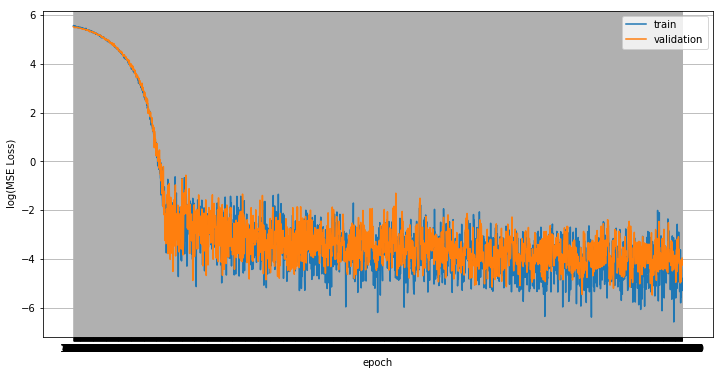

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(np.log(train_loss_list)[:30000], label="train")
plt.plot(np.log(valid_loss_list)[:30000], label="validation")
plt.xlabel("epoch")
plt.ylabel("log(MSE Loss)")
plt.xticks(
    [i for i in range(0, len(train_loss_list), num*1000 if num!=0 else 1)], 
    [str(i*1000) for i in range(len(train_loss_list)//(num*1000 if num!=0 else 1))]
)
plt.legend()
plt.grid()
plt.show()

# plt.plot(np.log(aug_train_loss)[:70000])
# plt.plot(np.log(aug_valid_loss)[:70000])

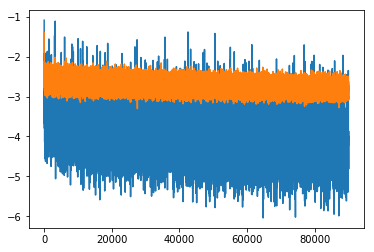

In [168]:
aug_train_loss = np.array(train_loss_list)
aug_valid_loss = np.array(valid_loss_list)

plt.plot(np.log(train_loss_list))
plt.plot(np.log(valid_loss_list))

In [ ]:
for epoch in range(10000):
    optimizer.zero_grad()
    pred = model(param, geo)
    loss = loss_func(pred, spec)
    loss.backward()
    optimizer.step()
    
    if epoch%100==0:
        print(float(loss))
        print(spec[:3])
        print(pred[:3])

## 分析

In [19]:
model.eval()

tmp = df.sample(frac=1)
# tmp = df.iloc[-500:]
pred = model(
    torch.tensor(tmp.values[:, 3:23].astype(np.float)).float().to(device), 
    torch.tensor(tmp.values[:, -10:-3].astype(np.float)).float().to(device)
)
loss = nn.MSELoss(reduction='none')(pred, torch.tensor(np.expand_dims(tmp.values[:, -3], 1).astype(np.float)).float().to(device))
tmp["loss"] = loss.detach().cpu().numpy()
model.train()

# col = df.columns[3:-3]
# for c in col:
# #     tmp.sort_values(by=[c])

# #     plt.title(c)
#     plt.scatter(tmp[c].tolist(), tmp["loss"].tolist())
#     plt.xlabel(c)
#     plt.ylabel("MSE Loss")
#     plt.show()

Model(
  (spec_layer): Linear(in_features=20, out_features=64, bias=True)
  (bn_spec): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (geo_layer): Linear(in_features=7, out_features=64, bias=True)
  (bn_geo): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=128, out_features=256, bias=True)
    (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ELU(alpha=1.0)
    (9): Linear(in_features=256, out_features=512, bias=True)
    (10): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, tr

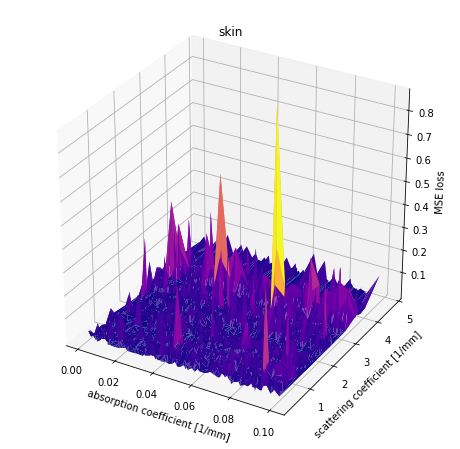

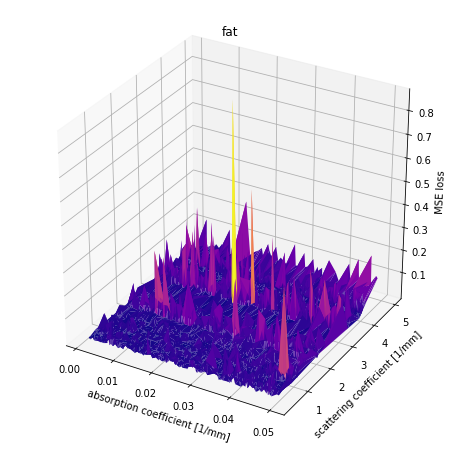

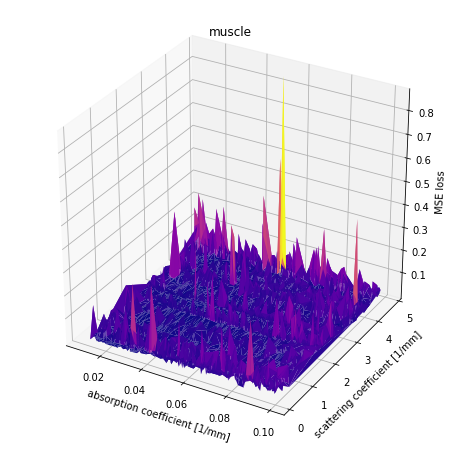

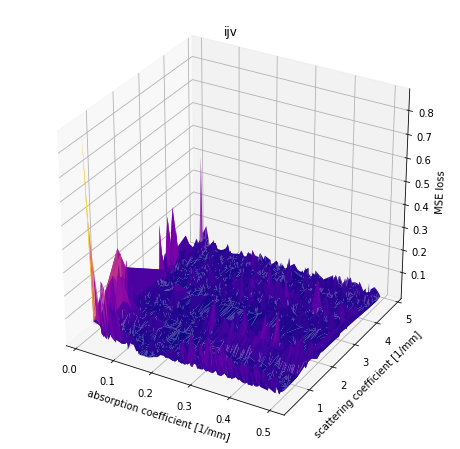

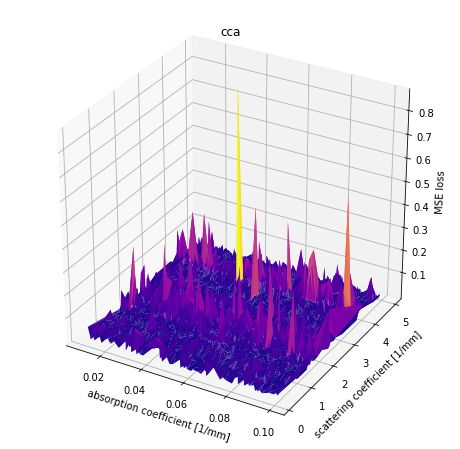

In [20]:
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d, Axes3D

fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection="3d")
surf = ax.plot_trisurf(tmp.skin_mua, tmp.skin_mus, tmp.loss, cmap=cm.plasma)
ax.set_title("skin")
ax.set_xlabel("absorption coefficient [1/mm]")
ax.set_ylabel("scattering coefficient [1/mm]")
ax.set_zlabel("MSE loss")
plt.savefig("train/log/skin.png")
plt.show()

fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection="3d")
surf = ax.plot_trisurf(tmp.fat_mua, tmp.fat_mus, tmp.loss, cmap=cm.plasma)
ax.set_title("fat")
ax.set_xlabel("absorption coefficient [1/mm]")
ax.set_ylabel("scattering coefficient [1/mm]")
ax.set_zlabel("MSE loss")
plt.savefig("train/log/fat.png")
plt.show()

fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection="3d")
surf = ax.plot_trisurf(tmp.muscle_mua, tmp.muscle_mus, tmp.loss, cmap=cm.plasma)
ax.set_title("muscle")
ax.set_xlabel("absorption coefficient [1/mm]")
ax.set_ylabel("scattering coefficient [1/mm]")
ax.set_zlabel("MSE loss")
plt.savefig("train/log/muscle.png")
plt.show()

fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection="3d")
surf = ax.plot_trisurf(tmp.ijv_mua, tmp.ijv_mus, tmp.loss, cmap=cm.plasma)
ax.set_title("ijv")
ax.set_xlabel("absorption coefficient [1/mm]")
ax.set_ylabel("scattering coefficient [1/mm]")
ax.set_zlabel("MSE loss")
plt.savefig("train/log/ijv.png")
plt.show()

fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection="3d")
surf = ax.plot_trisurf(tmp.cca_mua, tmp.cca_mus, tmp.loss, cmap=cm.plasma)
ax.set_title("cca")
ax.set_xlabel("absorption coefficient [1/mm]")
ax.set_ylabel("scattering coefficient [1/mm]")
ax.set_zlabel("MSE loss")
plt.savefig("train/log/cca.png")
plt.show()

In [179]:
df.iloc[:, 10:].describe()

fat_n    muscle_mua    muscle_mus      muscle_g      muscle_n  \
count  26900.000000  26900.000000  26900.000000  26900.000000  26900.000000   
mean       1.416289      0.055062      5.913302      0.896422      1.415755   
std        0.020034      0.025850      2.863438      0.053749      0.020080   
min        1.380020      0.010001      0.137341      0.800202      1.380070   
25%        1.400120      0.032842      3.660430      0.852392      1.398190   
50%        1.415880      0.055112      6.351750      0.894577      1.416520   
75%        1.433150      0.077114      8.461190      0.944280      1.432880   
max        1.449980      0.099998      9.948470      0.989505      1.449430   

            ijv_mua       ijv_mus         ijv_g         ijv_n       cca_mua  \
count  26900.000000  26900.000000  26900.000000  26900.000000  26900.000000   
mean       0.255307      2.535165      0.896052      1.415474      0.055159   
std        0.141516      1.486702      0.055183      0.019819      0.025907   
min        0.010041      0.110446      0.800203      1.380780      0.010001   
25%        0.133491      1.148840      0.847858      1.399580      0.032754   
50%        0.255174      2.695760      0.902243      1.414870      0.055175   
75%        0.377568      3.819790      0.942566      1.431650      0.077542   
max        0.499988      4.993110      0.989802      1.449900      0.099999   

       ...  skin_thickness  fat_thickness    ijv_radius     ijv_depth  \
count  ...    26900.000000   26900.000000  26900.000000  26900.000000   
mean   ...        1.004126       1.002170      5.709465     11.758497   
std    ...        0.291889       0.278063      2.234052      2.704080   
min    ...        0.500976       0.501006      2.504770      4.296920   
25%    ...        0.739310       0.776846      3.754680      9.887260   
50%    ...        1.020730       0.990495      5.199120     12.032400   
75%    ...        1.262500       1.230170      7.410880     13.915900   
max    ...        1.499240       1.499500     10.450800     15.997000   

         cca_radius     cca_depth  ijv_cca_distance  reflectance_20  \
count  26900.000000  26900.000000      26900.000000    26900.000000   
mean       3.383231     17.911773          7.963023      -18.530189   
std        0.570664      6.625276          1.368066        2.685381   
min        2.512410      5.032680          5.054690      -29.113786   
25%        2.897240     13.424600          6.837150      -20.449373   
50%        3.318780     19.753200          8.154930      -17.979108   
75%        3.850350     23.718600          9.016460      -16.344307   
max        4.474900     25.995800          9.998380      -13.537028   

       reflectance_24  reflectance_28  
count    2.690000e+04    2.690000e+04  
mean     2.757918e-08    1.297435e-08  
std      5.694190e-08    3.162913e-08  
min      6.200772e-15    7.088262e-17  
25%      2.338026e-10    4.641662e-11  
50%      4.162762e-09    1.195863e-09  
75%      2.800600e-08    1.047032e-08  
max      7.127339e-07    4.589903e-07  

[8 rows x 23 columns]

In [201]:
df.shape, df_low.shape

((17900, 33), (7100, 33))

In [200]:
df_low = df[
    (df["skin_mus"] < 3)|
    (df["fat_mus"] < 2.85)|
    (df["muscle_mus"] < 3.5)|
    (df["ijv_mus"] < 1.15)
]
# df_low = df[
#     (df["skin_mus"] < 3)&
#     (df["fat_mus"] < 2.85)&
#     (df["muscle_mus"] < 3.5)&
#     (df["ijv_mus"] < 1.15)
# ]

test = SpecData(df_low, False)

testloader = DataLoader(test, batch_size=32,
                        shuffle=True, num_workers=0)

In [188]:

model.eval()
for j, (_spec, geo, param) in enumerate(testloader):
    _spec, geo, param = torch.tensor(_spec).float(), torch.tensor(geo).float(), torch.tensor(param).float()

    _spec, geo, param = _spec.to(device), geo.to(device), param.to(device)
    _predict = model(param, geo)
    _loss = loss_func(_predict, _spec)

    valid_loss_ += [float(_loss.data)]

valid_loss_list += [np.mean(valid_loss_)]
# valid_loss_ = []


print("valid: {}".format(valid_loss_list[-1]))
print("{}\n{}".format(torch.exp(spec[0:5]), torch.exp(predict[0:5])))

/home/md703/toast/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


valid: 0.044602571706857906
tensor([[1.0762e-07],
        [2.2161e-08],
        [1.3427e-07],
        [3.7771e-08],
        [1.1556e-07]], device='cuda:0')
tensor([[8.3270e-08],
        [1.5858e-08],
        [9.6985e-08],
        [3.4649e-08],
        [1.0758e-07]], device='cuda:0', grad_fn=<ExpBackward>)


In [192]:
np.min(valid_loss_)

0.014480163343250751

In [209]:
model.train()
train_loss_list = []
for epoch in range(10000):
    train_loss_ = []
    valid_loss_ = []
    
    for i, (spec, geo, param) in enumerate(testloader):
        spec, geo, param = torch.tensor(spec).float(), torch.tensor(geo).float(), torch.tensor(param).float()
        spec, geo, param = spec.to(device), geo.to(device), param.to(device)
        optimizer.zero_grad()
        predict = model(param, geo)
        loss = loss_func(predict, spec)
        loss.backward()
        optimizer.step()
        train_loss_ += [float(loss.data)]
    train_loss_list += [np.mean(train_loss_)]

    
    if epoch % 1 == 0:
            print("epoch: {} | train: {}".format(
                epoch, train_loss_list[-1]
                 ))
            print("{}\n{}".format(torch.exp(spec[0:5]), torch.exp(predict[0:5])))
#             print("{}\n{}".format(spec[0:5]*std+mean, predict[0:5]*std+mean))

#         print(predict)
#         print(param)
#     scheduler.step(loss)

/home/md703/toast/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


epoch: 0 | train: 0.010445180202221818
tensor([[4.7783e-10],
        [5.5507e-08],
        [2.9293e-10],
        [9.1994e-10],
        [2.7273e-10]], device='cuda:0')
tensor([[3.5620e-10],
        [5.2589e-08],
        [3.3021e-10],
        [1.0191e-09],
        [2.6625e-10]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 1 | train: 0.010653864539874432
tensor([[1.5757e-08],
        [4.5425e-11],
        [1.9510e-07],
        [2.2440e-07],
        [1.2454e-09]], device='cuda:0')
tensor([[1.9481e-08],
        [4.5944e-11],
        [1.9979e-07],
        [2.3175e-07],
        [1.4002e-09]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 2 | train: 0.008270282135764556
tensor([[3.4826e-10],
        [1.1172e-08],
        [1.8512e-10],
        [4.8276e-09],
        [1.2774e-07]], device='cuda:0')
tensor([[3.3270e-10],
        [1.1928e-08],
        [2.0465e-10],
        [4.9812e-09],
        [1.2436e-07]], device='cuda:0', grad_fn=<ExpBackward>)
epoch: 3 | train: 0.010541042357553132
tensor(

In [ ]:
1`
